#### Import các thư viện cần cho mô hình predict obesity

In [2]:
from pandas import read_excel, get_dummies
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#### GĐ1 Tiền xử lý dữ liệu

In [3]:
df = read_excel('Obesity_Dataset.xlsx')
df.head()

,Sex,Age,Height,Overweight_Obese_Family,Consumption_of_Fast_Food,Frequency_of_Consuming_Vegetables,Number_of_Main_Meals_Daily,Food_Intake_Between_Meals,Smoking,Liquid_Intake_Daily,Calculation_of_Calorie_Intake,Physical_Excercise,Schedule_Dedicated_to_Technology,Type_of_Transportation_Used,Class
0,2,18,155,2,2,3,1,3,2,1,2,3,3,4,2
1,2,18,158,2,2,3,1,1,2,1,2,1,3,3,2
2,2,18,159,2,2,2,1,3,2,3,2,2,3,4,2
3,2,18,162,2,2,2,2,2,2,2,2,1,3,4,2
4,2,18,165,2,1,2,1,3,2,1,2,3,3,2,2


In [ ]:
print(df.dtypes) # Đọc kiểu dữ liệu

Sex                                  int64
Age                                  int64
Height                               int64
Overweight_Obese_Family              int64
Consumption_of_Fast_Food             int64
Frequency_of_Consuming_Vegetables    int64
Number_of_Main_Meals_Daily           int64
Food_Intake_Between_Meals            int64
Smoking                              int64
Liquid_Intake_Daily                  int64
Calculation_of_Calorie_Intake        int64
Physical_Excercise                   int64
Schedule_Dedicated_to_Technology     int64
Type_of_Transportation_Used          int64
Class                                int64
dtype: object


In [5]:
print(df.describe())

               Sex          Age       Height  Overweight_Obese_Family  \
count  1610.000000  1610.000000  1610.000000              1610.000000   
mean      1.557764    33.115528   167.741615                 1.834783   
std       0.496806     9.835076     7.979873                 0.371492   
min       1.000000    18.000000   150.000000                 1.000000   
25%       1.000000    25.000000   161.000000                 2.000000   
50%       2.000000    32.000000   168.000000                 2.000000   
75%       2.000000    41.000000   174.000000                 2.000000   
max       2.000000    54.000000   193.000000                 2.000000   

       Consumption_of_Fast_Food  Frequency_of_Consuming_Vegetables  \
count               1610.000000                        1610.000000   
mean                   1.729193                           2.063354   
std                    0.444515                           0.746043   
min                    1.000000                           1.00

In [6]:
# Kiểm tra null
df.isna().sum()

Sex                                  0
Age                                  0
Height                               0
Overweight_Obese_Family              0
Consumption_of_Fast_Food             0
Frequency_of_Consuming_Vegetables    0
Number_of_Main_Meals_Daily           0
Food_Intake_Between_Meals            0
Smoking                              0
Liquid_Intake_Daily                  0
Calculation_of_Calorie_Intake        0
Physical_Excercise                   0
Schedule_Dedicated_to_Technology     0
Type_of_Transportation_Used          0
Class                                0
dtype: int64

In [ ]:
df['Class'].value_counts() # Kiểm tra độ chênh của biến mục tiêu (y)

# 1. Thiếu cân, 2. Tiêu chuẩn, 3. Thừa cân, 4. Béo phì

Class
2    658
3    592
4    287
1     73
Name: count, dtype: int64

#### Khái quát sơ về biến định tính và biến định lượng trong data

Biến định tính :

 1. Biến định tính nhị phân : chỉ có 2 giá trị ( ví dụ : nam/nữ , yes/no )
 2. Biến định tính đa giá trị : >= 3 giá trị ( ví dụ : Loại xe = Ô tô / Xe máy / Xe đạp / Xe điện )

Biến định lượng :

 1. Biến rời rạc : Số nguyên, đếm được từng đơn vị, không có giá trị lẻ (ví dụ : Số người, Số vé)
 2. Biến liên tục : Có thể chia nhỏ tới vô hạn, gồm số lẻ, số thập phân (ví dụ : Cân nặng, Chiều cao, Nhiệt độ, Doanh thu)


In [8]:
# Hàm kiểm tra biến định tính
def qualitative_columns(df):
    """Kiểm tra và phân loại các cột định tính trong DataFrame."""
    result = {
        'cat_binary': [],
        'cat_multiclass': []
    }
    
    for col in df.columns: # Duyệt qua các cột của data
        if df[col].dtype == 'object' or df[col].dtype.name == 'category': # kiểm tra các cột có giá trị là chuỗi hay có giá trị lặp lại hay không
            unique_vals = df[col].nunique() # đếm giá trị duy nhất (bỏ qua NaN) bằng hàm nunique()
            result['cat_binary' if unique_vals == 2 else 'cat_multiclass'].append(col) 
            # in ra kết quả nếu định tính nhị phân, nếu định tính đa giá trị và append(col) thêm tên cột vào danh sách tương ứng
    
    # Kiểm tra và in thông báo
    has_binary = bool(result['cat_binary']) # nếu danh sách rỗng [] return false, nếu có ít nhất 1 cột : true
    has_multiclass = bool(result['cat_multiclass'])
    
    print("Kiểm tra biến định tính:")
    print(f"Có biến định tính nhị phân (2) : {'Có' if has_binary else 'Không'}")
    if has_binary:
        print(f"  - Cột nhị phân: {result['cat_binary']}")
        print(f"Có biến định tính đa giá trị (>=3) : {'Có' if has_multiclass else 'Không'}")
    print(f"Có biến định tính đa giá trị (>=3) : {'Có' if has_multiclass else 'Không'}")
    if has_multiclass:
        print(f"  - Cột đa giá trị: {result['cat_multiclass']}") 
    
    return result

# Gọi hàm
result = qualitative_columns(df)

# hoặc dùng cái này print(df.describe(include='object')), nếu nó báo lỗi null thì không có biến định tính nào
# nhưng obesity dataset trên kaggle này người ta xử lý hết rồi 

Kiểm tra biến định tính:
Có biến định tính nhị phân (2) : Không
Có biến định tính đa giá trị (>=3) : Không


#### GĐ2 Chia tập data và huấn luyện mô hình

In [9]:
# mã hóa đầu ra y (cột Class)
label_encoder = LabelEncoder()
y_endcoder = label_encoder.fit_transform(df['Class'])

#### Phần này giải thích vì sao cần mã hóa ha

##### 1. Lỗi gặp phải nếu không mã hóa nhãn
**Lỗi:** `ValueError: Invalid classes inferred from unique values of y. Expected: [0 1 2 3], got [1 2 3 4]`  
- **Nguyên nhân:** Nhãn trong `y_train` là `[1, 2, 3, 4]`, nhưng XGBoost yêu cầu nhãn phải bắt đầu từ 0: `[0, 1, 2, 3]`.  
- **Hậu quả:** XGBoost không hiểu đúng số lớp (4 lớp), dẫn đến lỗi.

---

##### 2. Cách nhãn hoạt động trong mô hình và XGBoost
- Trong bài toán phân loại, nhãn (labels) là các lớp cần dự đoán (ở đây: 4 lớp từ cột `Class`).
- XGBoost yêu cầu nhãn là số nguyên liên tục **bắt đầu từ 0** (ví dụ: `[0, 1, 2, 3]`) để:
  - Ánh xạ đúng vào các lớp: 0 → lớp 0, 1 → lớp 1, v.v.
  - Tính toán xác suất cho từng lớp (dùng `multi:softmax` hoặc `multi:softprob`).
- Nếu nhãn không bắt đầu từ 0 (như `[1, 2, 3, 4]`), XGBoost sẽ hiểu sai số lớp hoặc ánh xạ.

---

##### 3. Giải pháp: Mã hóa nhãn bằng `LabelEncoder`
**Mục đích:** Chuyển nhãn từ `[1, 2, 3, 4]` thành `[0, 1, 2, 3]` để đáp ứng yêu cầu của XGBoost.  
**Code:**
```python
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Class'])

In [ ]:
X = df.drop(columns=['Class'])  
y = y_endcoder # gán y bằng y đã mã hóa nhãn

In [11]:
# Chuẩn hóa data
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [12]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42 )

In [13]:
# Train xgboost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [14]:
xgb.score(X_train, y_train), xgb.score(X_test, y_test)

(1.0, 0.8571428571428571)

In [15]:
# Train dummy
dummy = DummyClassifier()
dummy.fit(X_train, y_train)

DummyClassifier()

In [16]:
dummy.score(X_train, y_train), dummy.score(X_test, y_test)

(0.4138198757763975, 0.38819875776397517)

##### Mồ hình dummy này chắc cút rồi, độ chính xác thấp quá

#### Overfitting
- Nghĩa là mô hình học quá kĩ vào train data nhưng khi gặp dữ liệu mới ( test data ) thì không dự đoán được tốt đó là lý do cái kết quả train : 100% và thực tế dự đoán chỉ ~ 85%, thấy giống mình đó, học nhiều mà vẫn ngu

- (1.0, 0.8571428571428571) , (train accuracy, test accuracy) 

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       0.89      0.89      0.89       125
           2       0.84      0.83      0.84       131
           3       0.80      0.81      0.80        53

    accuracy                           0.86       322
   macro avg       0.86      0.88      0.87       322
weighted avg       0.86      0.86      0.86       322



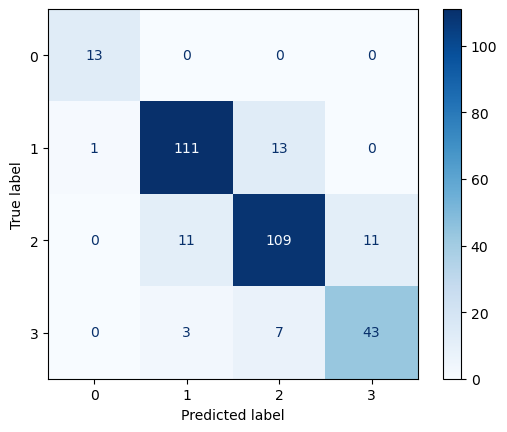

In [17]:
# Dự đoán
y_pred = xgb.predict(X_test)

# Báo cáo
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot(cmap='Blues')

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        13
           1       0.39      1.00      0.56       125
           2       1.00      0.00      0.00       131
           3       1.00      0.00      0.00        53

    accuracy                           0.39       322
   macro avg       0.85      0.25      0.14       322
weighted avg       0.76      0.39      0.22       322



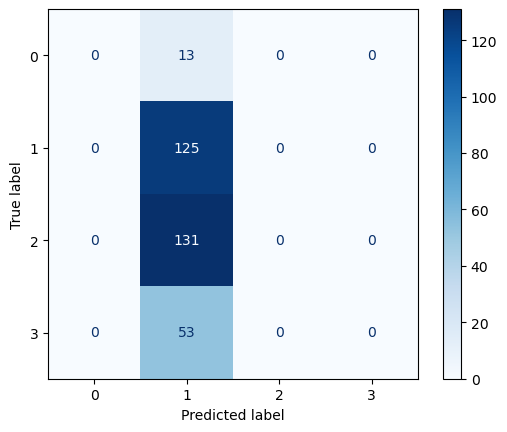

In [18]:
# Dự đoán
y_pred = dummy.predict(X_test)

# Báo cáo
print(classification_report(y_test, y_pred, zero_division=1))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot(cmap='Blues')